# Sinaplots

from here https://cran.r-project.org/web/packages/sinaplot/vignettes/SinaPlot.html

A cool way to display data with as much info as possible, including the number of data points, the distribution and density, mean or median, and outliers. Now in python, because I didn't want to write my 2nd year report this afternoon.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sinaplot import sinaplot
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

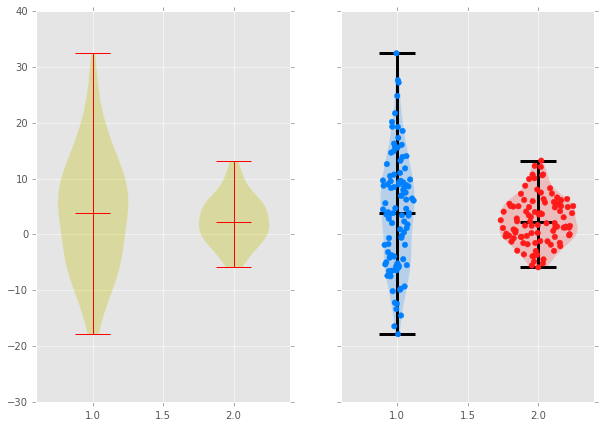

In [2]:
y1 = np.random.normal(4, 10, 100)
y2 = np.random.normal(3, 4, 100)
data = np.vstack((y1, y2)).T

fig, ax = plt.subplots(figsize=(10, 7), ncols=2, sharey=True, sharex=True)

vio = ax[0].violinplot(
    data, points=200, vert=True, widths=0.5, 
    showextrema=True, showmedians=True, bw_method=0.5)

sina = sinaplot(
    data, showmedians=True, showextrema=True,
    scaled=True, vert=True, ax=ax[1], show_violin=True,
    scatter_kwargs={'s': 30, 'color': ['#0080ff', '#ff1a1a'], 'zorder': 2},
    line_kwargs={'lw': 3, 'color': 'k', 'zorder': 1})

plt.show()

In [3]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

C:\Users\Matthew\Miniconda3\envs\jupyter_python3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


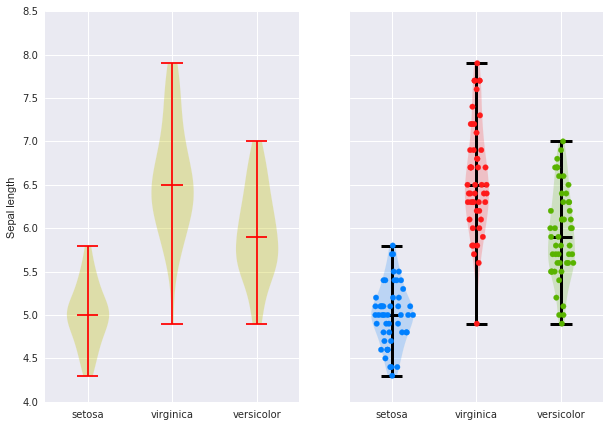

In [6]:
species = list(set(iris.species))
grouped_sepal = np.array([
        iris[iris.species==s].sepal_length for s in species]).T

fig, ax = plt.subplots(figsize=(10, 7), ncols=2, sharey=True, sharex=True)

vio = ax[0].violinplot(
    grouped_sepal, points=200, vert=True, widths=0.5, 
    showextrema=True, showmedians=True, bw_method=0.5)

sina = sinaplot(
    grouped_sepal, showmedians=True, showextrema=True,
    scaled=True, vert=True, ax=ax[1], show_violin=True,
    scatter_kwargs={'s': 30, 'color': ['#0080ff', '#ff1a1a', '#59b300'], 'zorder': 2},
    line_kwargs={'lw': 3, 'color': 'k', 'zorder': 1})

ax[0].set(ylabel='Sepal length', xticks=(1, 2, 3), xticklabels=species)
plt.show()